**Import Library**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.dates as mdates

import warnings
warnings.filterwarnings('ignore')

#by_yunus_widyatama

**Baca semua sheet dari file**

In [2]:
df_all = []
for tahun in range(2006, 2025):
    df = pd.read_excel("Data Penumpang Bandara 2006-2004 YUNUS.xlsx", sheet_name=str(tahun), header=5)
    df['Bandara'] = df['Bandara'].fillna(method='ffill')
    df['Tahun'] = df['Tahun'].fillna(method='ffill')
    df_all.append(df)

df_all = pd.concat(df_all, ignore_index=True)
df_all

,Bandara,Tahun,Bulan,Timeseries,Domestik,Internasional
0,Kualanamu-Medan,2006.0,Januari,2006-01-01,169652,32757
1,Kualanamu-Medan,2006.0,Februari,2006-02-01,138623,33073
2,Kualanamu-Medan,2006.0,Maret,2006-03-01,125954,32790
3,Kualanamu-Medan,2006.0,April,2006-04-01,156892,37047
4,Kualanamu-Medan,2006.0,Mei,2006-05-01,147322,34629
...,...,...,...,...,...,...
903,Ngurah Rai-Bali,2024.0,Juli,2024-07-01,456189,659161
904,Ngurah Rai-Bali,2024.0,Agustus,2024-08-01,450506,687823
905,Ngurah Rai-Bali,2024.0,September,2024-09-01,423374,649636
906,Ngurah Rai-Bali,2024.0,Oktober,2024-10-01,386797,651246


**Format kolom Timeseries ke datetime**

In [3]:
df_all['Timeseries'] = pd.to_datetime(df_all['Timeseries'])
df_all = df_all.sort_values(by='Timeseries')

**Siapkan data nilai bandara**

In [4]:
bandara_list = df_all['Bandara'].unique()
all_forecasts = []
evaluasi_list = []

**Loop untuk masing-masing bandar**


📍 Bandara: Kualanamu-Medan
  Evaluasi Bandara Kualanamu-Medan
  Domestik     → MAPE: 14.56%, MAE: 10.22%, RMSE: 14.67%
  Internasional→ MAPE: 12.45%, MAE: 10.39%, RMSE: 14.71%


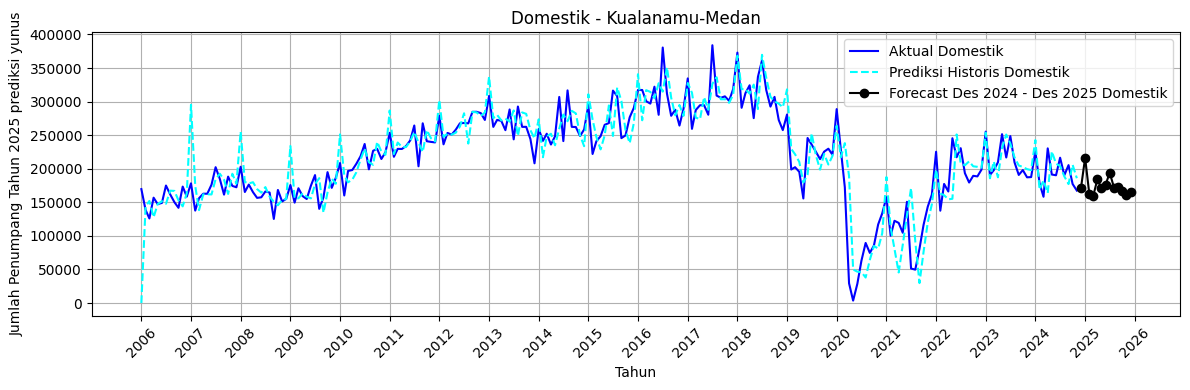

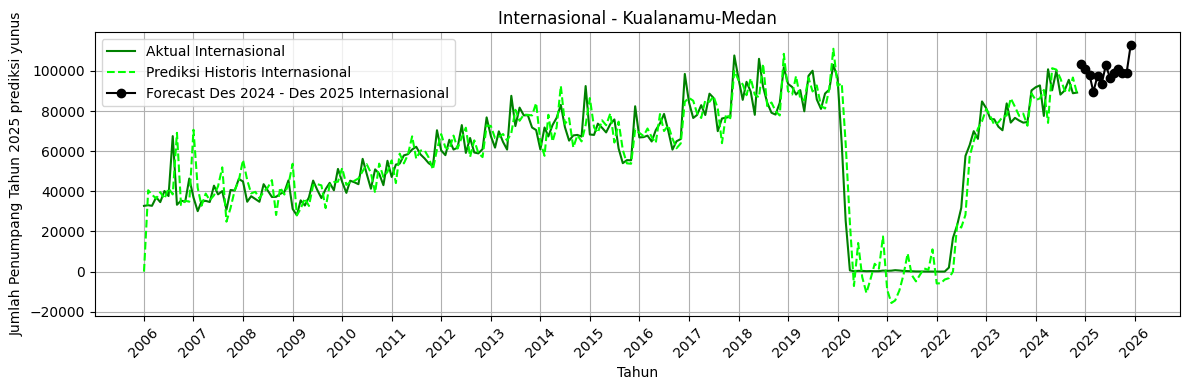


📍 Bandara: Ngurah Rai-Bali
  Evaluasi Bandara Ngurah Rai-Bali
  Domestik     → MAPE: 18.15%, MAE: 10.82%, RMSE: 15.49%
  Internasional→ MAPE: 13.67%, MAE: 7.08%, RMSE: 11.29%


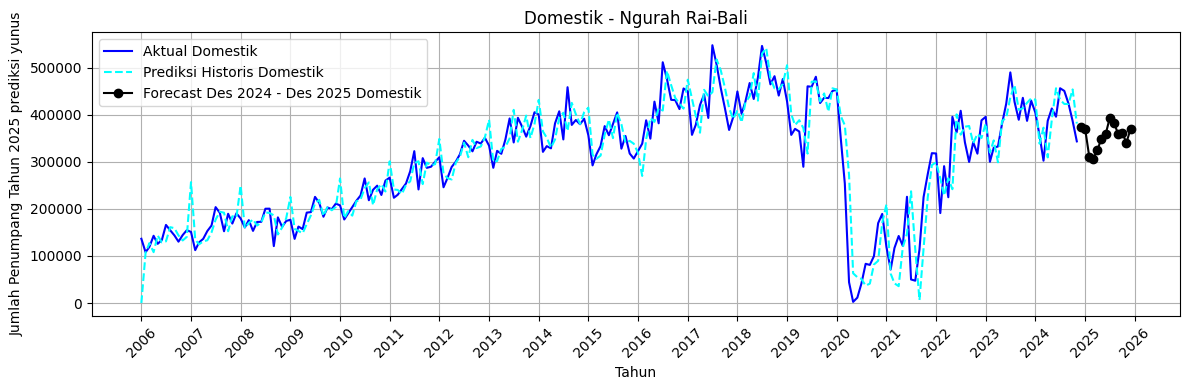

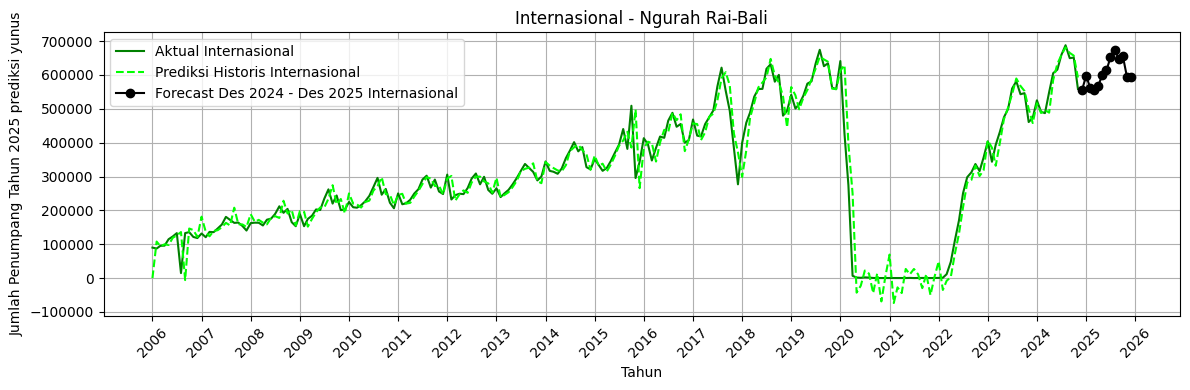


📍 Bandara: Juanda-Surabaya
  Evaluasi Bandara Juanda-Surabaya
  Domestik     → MAPE: 19.88%, MAE: 10.96%, RMSE: 17.18%
  Internasional→ MAPE: 15.75%, MAE: 13.19%, RMSE: 19.35%


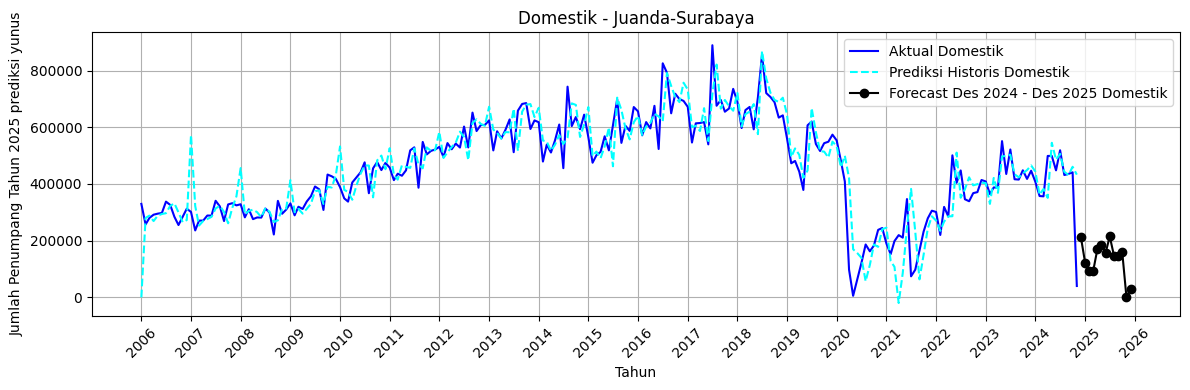

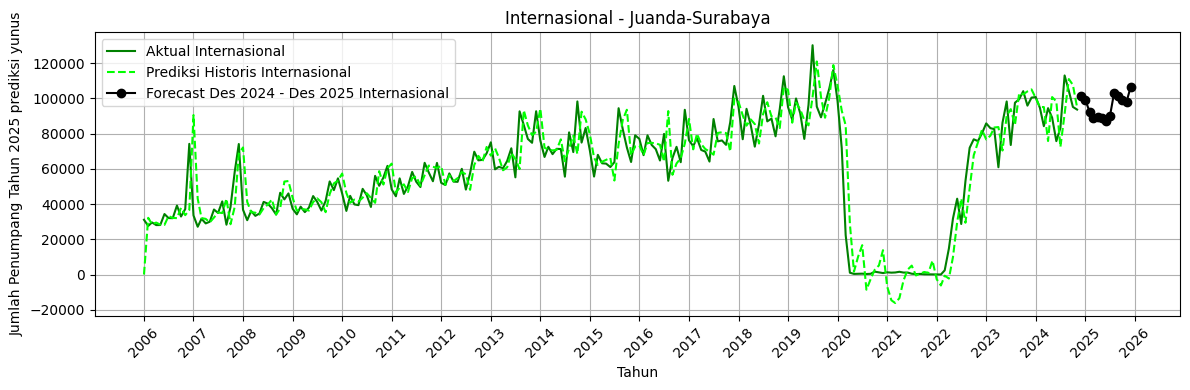


📍 Bandara: Soekarno Hatta-Jakarta
  Evaluasi Bandara Soekarno Hatta-Jakarta
  Domestik     → MAPE: 16.33%, MAE: 8.81%, RMSE: 13.78%
  Internasional→ MAPE: 18.67%, MAE: 8.34%, RMSE: 12.27%


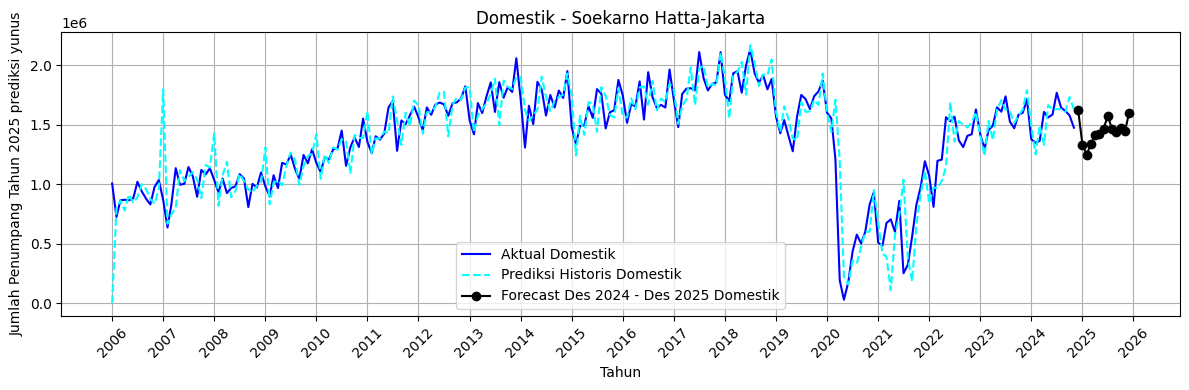

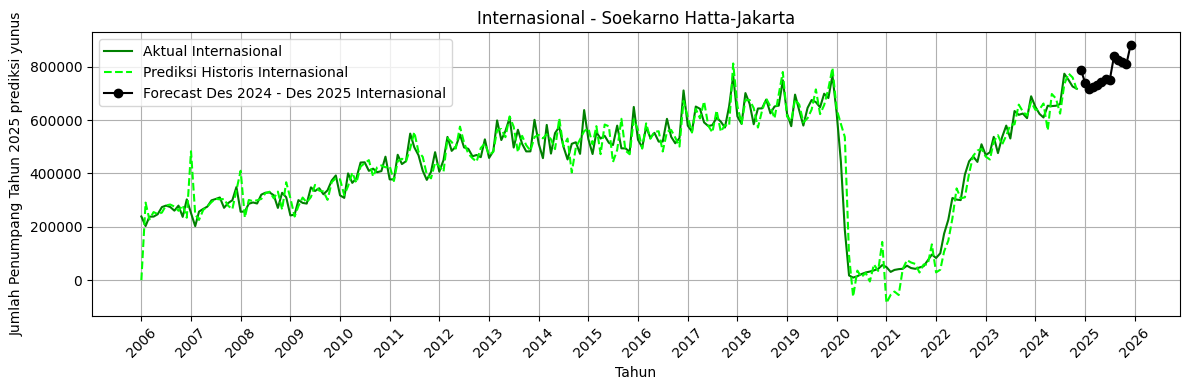

In [5]:
for bandara in bandara_list:
    df_bandara = df_all[df_all['Bandara'] == bandara].copy()
    df_bandara.set_index('Timeseries', inplace=True)

    if len(df_bandara) < 24:
        continue

    try:
        print(f"\n📍 Bandara: {bandara}")

        # Model SARIMA untuk Domestik
        model_dom = sm.tsa.statespace.SARIMAX(df_bandara['Domestik'],
                                              order=(1,1,1),
                                              seasonal_order=(1,1,1,12),
                                              enforce_stationarity=False,
                                              enforce_invertibility=False)
        result_dom = model_dom.fit(disp=False)

        # Model SARIMA untuk Internasional
        model_int = sm.tsa.statespace.SARIMAX(df_bandara['Internasional'],
                                              order=(1,1,1),
                                              seasonal_order=(1,1,1,12),
                                              enforce_stationarity=False,
                                              enforce_invertibility=False)
        result_int = model_int.fit(disp=False)

        # Evaluasi pakai MAPE
        y_true_dom = df_bandara['Domestik'].dropna()
        y_pred_dom = result_dom.fittedvalues

        y_true_int = df_bandara['Internasional'].dropna()
        y_pred_int = result_int.fittedvalues

        # Samakan index
        common_idx_dom = y_true_dom.index.intersection(y_pred_dom.index)
        common_idx_int = y_true_int.index.intersection(y_pred_int.index)

        y_true_dom_eval = y_true_dom.loc[common_idx_dom]
        y_pred_dom_eval = y_pred_dom.loc[common_idx_dom]

        y_true_int_eval = y_true_int.loc[common_idx_int]
        y_pred_int_eval = y_pred_int.loc[common_idx_int]

        # Hapus nilai aktual terlalu kecil untuk MAPE
        y_true_dom_eval = y_true_dom_eval[y_true_dom_eval > 10000]
        y_pred_dom_eval = y_pred_dom_eval[y_true_dom_eval.index]

        y_true_int_eval = y_true_int_eval[y_true_int_eval > 10000]
        y_pred_int_eval = y_pred_int_eval[y_true_int_eval.index]

        # Hitung MAPE
        mape_dom = np.mean(np.abs((y_true_dom_eval - y_pred_dom_eval) / y_true_dom_eval)) *100
        mape_int = np.mean(np.abs((y_true_int_eval - y_pred_int_eval) / y_true_int_eval)) *100

        # Hitung MAE
        mae_dom = mean_absolute_error(y_true_dom_eval, y_pred_dom_eval)
        mae_int = mean_absolute_error(y_true_int_eval, y_pred_int_eval)

        # Hitung RMSE
        rmse_dom = np.sqrt(mean_squared_error(y_true_dom_eval, y_pred_dom_eval))
        rmse_int = np.sqrt(mean_squared_error(y_true_int_eval, y_pred_int_eval))

        # Tambahkan ini untuk hitung proporsi MAE & RMSE terhadap rata-rata aktual
        mean_dom = y_true_dom_eval.mean()
        mean_int = y_true_int_eval.mean()

        prop_mae_dom = mae_dom / mean_dom * 100
        prop_rmse_dom = rmse_dom / mean_dom * 100

        prop_mae_int = mae_int / mean_int * 100
        prop_rmse_int = rmse_int / mean_int * 100

        # Simpan evaluasi
        evaluasi_list.append({
            'Bandara': bandara,
            'MAPE Domestik (%)': round(mape_dom, 2),
            'MAE Domestik (%)': round(prop_mae_dom, 2),
            'RMSE Domestik (%)': round(prop_rmse_dom, 2),
            'MAPE Internasional (%)': round(mape_int, 2),
            'MAE Internasional (%)': round(prop_mae_int, 2),
            'RMSE Internasional (%)': round(prop_rmse_int, 2)
        })

        # Tampilkan hasil evaluasi di output

        print(f"  Evaluasi Bandara {bandara}")
        print(f"  Domestik     → MAPE: {mape_dom:.2f}%, MAE: {prop_mae_dom:.2f}%, RMSE: {prop_rmse_dom:.2f}%")
        print(f"  Internasional→ MAPE: {mape_int:.2f}%, MAE: {prop_mae_int:.2f}%, RMSE: {prop_rmse_int:.2f}%")

        # Forecast 13 bulan (Des 2024 - Des 2025)
        start_forecast = pd.to_datetime("2024-12-01")
        future_dates = [start_forecast + DateOffset(months=x) for x in range(0,13)]

        forecast_dom = result_dom.forecast(steps=13)
        forecast_int = result_int.forecast(steps=13)


        # Ganti semua prediksi negatif menjadi 0
        forecast_dom = forecast_dom.apply(lambda x: max(x, 0))
        forecast_int = forecast_int.apply(lambda x: max(x, 0))

        forecast_df = pd.DataFrame({
            'Bandara': bandara,
            'Timeseries': future_dates,
            'Prediksi Domestik': forecast_dom.round(0).astype(int),
            'Prediksi Internasional': forecast_int.round(0).astype(int)
        })


        forecast_df.insert(0, 'No', range(1, len(forecast_df)+1))
        all_forecasts.append(forecast_df)

        # ===== Grafik Domestik =====
        plt.figure(figsize=(12, 4))
        plt.plot(df_bandara.index, df_bandara['Domestik'], label='Aktual Domestik', color='blue')
        plt.plot(y_pred_dom.index, y_pred_dom, label='Prediksi Historis Domestik', linestyle='--', color='cyan')
        plt.plot(future_dates, forecast_dom, label='Forecast Des 2024 - Des 2025 Domestik', marker='o', color='black')
        plt.title(f"Domestik - {bandara}")
        plt.xlabel("Tahun")
        plt.ylabel("Jumlah Penumpang Tahun 2025 prediksi yunus")
        plt.legend()
        plt.grid(True)

        plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

        # ===== Grafik Internasional =====
        plt.figure(figsize=(12, 4))
        plt.plot(df_bandara.index, df_bandara['Internasional'], label='Aktual Internasional', color='green')
        plt.plot(y_pred_int.index, y_pred_int, label='Prediksi Historis Internasional', linestyle='--', color='lime')
        plt.plot(future_dates, forecast_int, label='Forecast Des 2024 - Des 2025 Internasional', marker='o', color='black')
        plt.title(f"Internasional - {bandara}")
        plt.xlabel("Tahun")
        plt.ylabel("Jumlah Penumpang Tahun 2025 prediksi yunus")
        plt.legend()
        plt.grid(True)

        plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"❌ Gagal di bandara {bandara}: {e}")


**Gabungkan semua hasil**

In [6]:
hasil_forecast = pd.concat(all_forecasts)
hasil_forecast['Prediksi Domestik'] = hasil_forecast['Prediksi Domestik'].astype(int)
hasil_forecast['Prediksi Internasional'] = hasil_forecast['Prediksi Internasional'].astype(int)

hasil_forecast.to_excel("hasil_forecast_2025.xlsx", index=False)

df_evaluasi = pd.DataFrame(evaluasi_list)

df_evaluasi['MAE Domestik (%)'] = df_evaluasi['MAE Domestik (%)'].astype(float).round(2)
df_evaluasi['RMSE Domestik (%)'] = df_evaluasi['RMSE Domestik (%)'].astype(float).round(2)
df_evaluasi['MAE Internasional (%)'] = df_evaluasi['MAE Internasional (%)'].astype(float).round(2)
df_evaluasi['RMSE Internasional (%)'] = df_evaluasi['RMSE Internasional (%)'].astype(float).round(2)


# urutan kolom yang terstruktur
df_evaluasi = df_evaluasi[[
  'Bandara',
    'MAPE Domestik (%)',
    'MAPE Internasional (%)',
    'MAE Domestik (%)',
    'MAE Internasional (%)',
    'RMSE Domestik (%)',
    'RMSE Internasional (%)'
]]

In [7]:
hasil_forecast

,No,Bandara,Timeseries,Prediksi Domestik,Prediksi Internasional
2024-12-01,1,Kualanamu-Medan,2024-12-01,170591,103254
2025-01-01,2,Kualanamu-Medan,2025-01-01,216301,100897
2025-02-01,3,Kualanamu-Medan,2025-02-01,162202,97958
2025-03-01,4,Kualanamu-Medan,2025-03-01,158838,89533
2025-04-01,5,Kualanamu-Medan,2025-04-01,184231,97676
2025-05-01,6,Kualanamu-Medan,2025-05-01,170860,93503
2025-06-01,7,Kualanamu-Medan,2025-06-01,176439,102895
2025-07-01,8,Kualanamu-Medan,2025-07-01,194113,96652
2025-08-01,9,Kualanamu-Medan,2025-08-01,172063,98758
2025-09-01,10,Kualanamu-Medan,2025-09-01,173205,100838


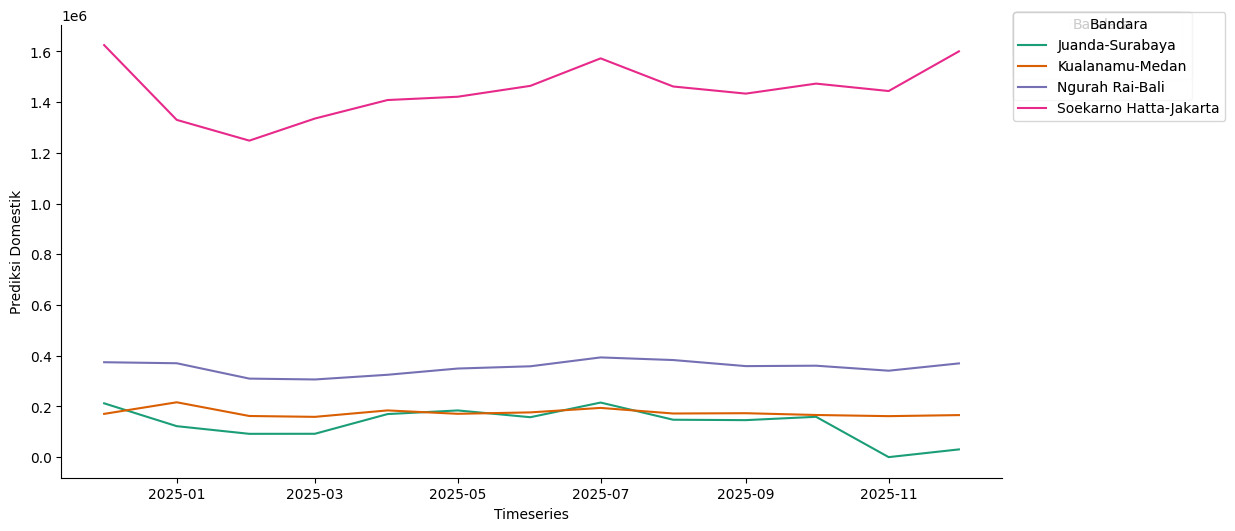

In [8]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Timeseries']
  ys = series['Prediksi Domestik']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = hasil_forecast.sort_values('Timeseries', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Bandara')):
  _plot_series(series, series_name, i)
  fig.legend(title='Bandara', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Timeseries')
_ = plt.ylabel('Prediksi Domestik')

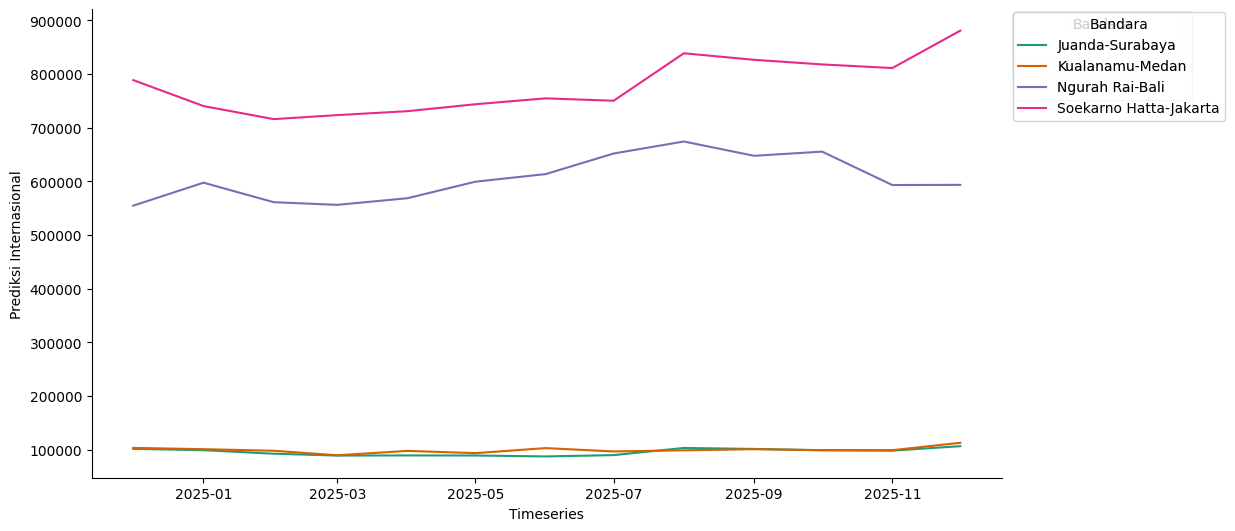

In [9]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Timeseries']
  ys = series['Prediksi Internasional']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = hasil_forecast.sort_values('Timeseries', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Bandara')):
  _plot_series(series, series_name, i)
  fig.legend(title='Bandara', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Timeseries')
_ = plt.ylabel('Prediksi Internasional')

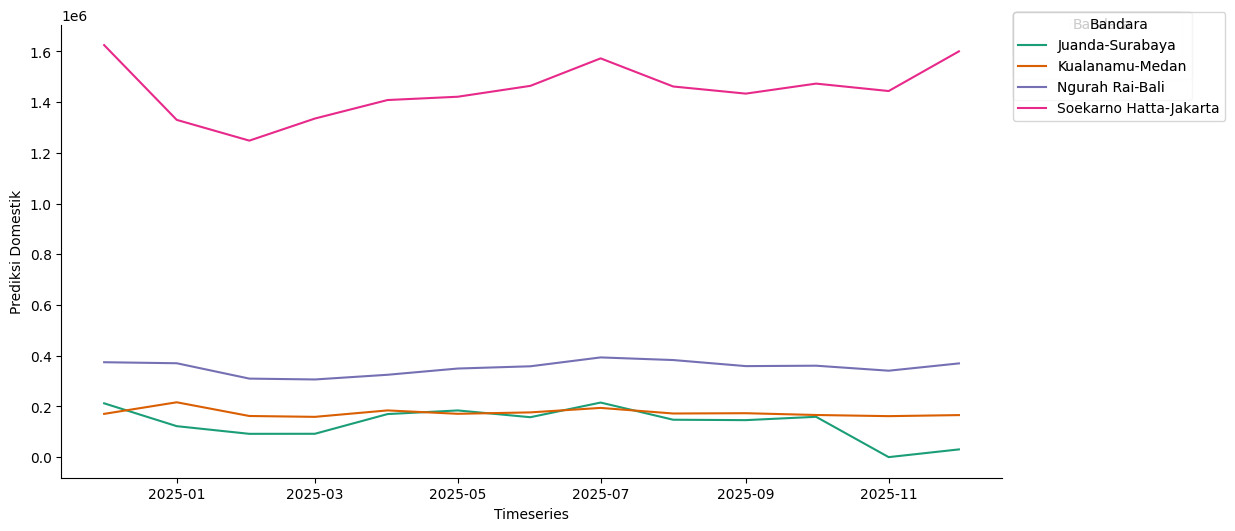

In [10]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Timeseries']
  ys = series['Prediksi Domestik']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = hasil_forecast.sort_values('Timeseries', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Bandara')):
  _plot_series(series, series_name, i)
  fig.legend(title='Bandara', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Timeseries')
_ = plt.ylabel('Prediksi Domestik')

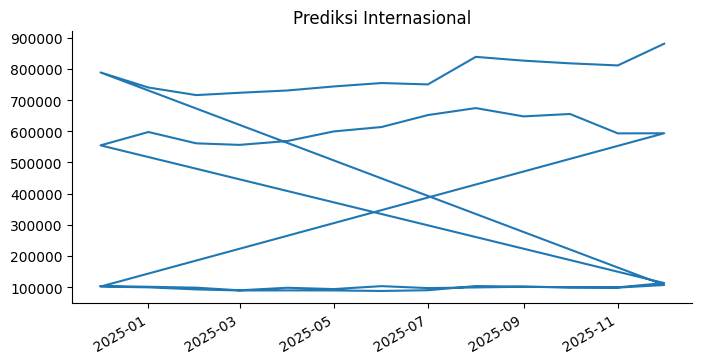

In [11]:
from matplotlib import pyplot as plt
hasil_forecast['Prediksi Internasional'].plot(kind='line', figsize=(8, 4), title='Prediksi Internasional')
plt.gca().spines[['top', 'right']].set_visible(False)

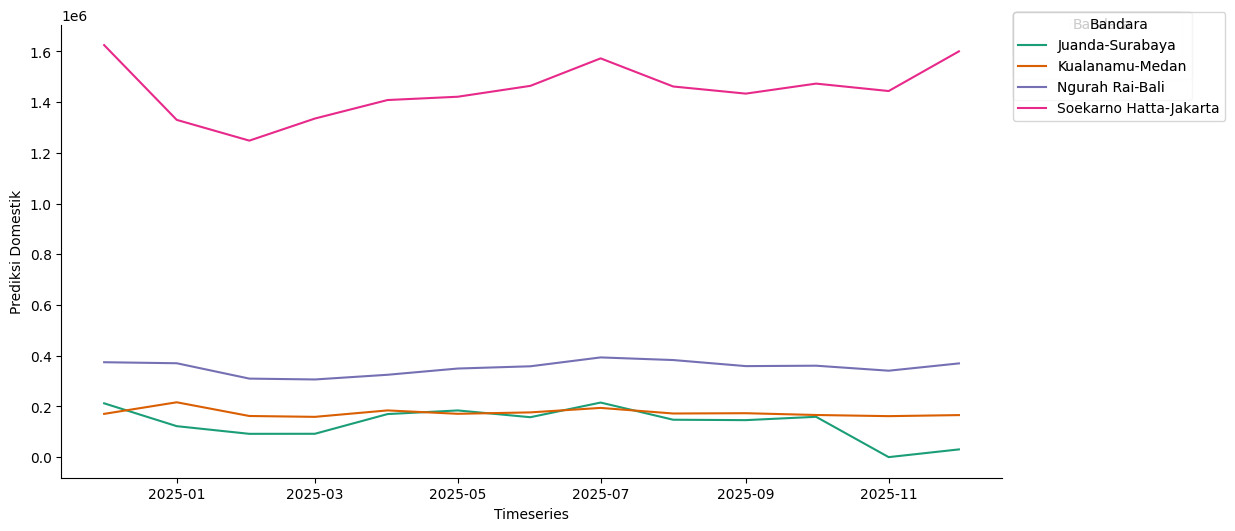

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Timeseries']
  ys = series['Prediksi Domestik']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = hasil_forecast.sort_values('Timeseries', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Bandara')):
  _plot_series(series, series_name, i)
  fig.legend(title='Bandara', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Timeseries')
_ = plt.ylabel('Prediksi Domestik')

In [13]:
df_evaluasi

,Bandara,MAPE Domestik (%),MAPE Internasional (%),MAE Domestik (%),MAE Internasional (%),RMSE Domestik (%),RMSE Internasional (%)
0,Kualanamu-Medan,14.56,12.45,10.22,10.39,14.67,14.71
1,Ngurah Rai-Bali,18.15,13.67,10.82,7.08,15.49,11.29
2,Juanda-Surabaya,19.88,15.75,10.96,13.19,17.18,19.35
3,Soekarno Hatta-Jakarta,16.33,18.67,8.81,8.34,13.78,12.27
